In [71]:
import pandas as pd
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

import lime
from lime.lime_tabular import LimeTabularExplainer

from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler 
from sklearn.impute import SimpleImputer

In [72]:
data = pd.read_csv('df_dash.csv')
data.head()

,SK_ID_CURR,adaboost_proba,adaboost_result,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,...,weekday_process_SATURDAY,type_suite_Family,flag_realty_Y,flag_car_Y,anciennete_pro/age,credit/revenu,credit/revenu/age,EXT_SOURCE_2/credit,EXT_SOURCE_2/age,nb_enf/age
0,100001,0.499798,0,-19241,-812,-1740.0,-2329,0.018850,1,18,...,0,0,1,0,0.121044,4.213333,-0.000219,1.388281e-06,-0.000041,-0.000000
1,100005,0.499831,0,-18064,-1623,0.0,-4469,0.035792,0,9,...,0,0,1,0,0.247398,2.250182,-0.000125,1.309234e-06,-0.000016,-0.000000
2,100013,0.500265,1,-20038,-3503,-856.0,-4458,0.019101,0,14,...,0,0,1,1,0.222477,3.275378,-0.000163,1.055065e-06,-0.000035,-0.000000
3,100028,0.511138,1,-13976,-4208,-1805.0,-1866,0.026392,0,11,...,0,0,1,0,0.133515,5.000000,-0.000358,3.236045e-07,-0.000036,-0.000143
4,100038,0.500167,1,-13040,-4262,-821.0,-2191,0.010032,0,5,...,0,0,0,1,0.168021,3.475000,-0.000266,6.805552e-07,-0.000033,-0.000077


# Observons les similarités entre les clients.
https://www.drawingfromdata.com/making-a-pairwise-distance-matrix-with-pandas

In [73]:
from sklearn.metrics.pairwise import euclidean_distances

# méthode pour petit dataset

#pairwise_dist_mat = euclidean_distances(data)
#pairwise_dist_mat

In [74]:
# Similarité entre 2 clients

summary = data.set_index('SK_ID_CURR')

from scipy.spatial.distance import pdist

pdist(summary.loc[[100001, 100005]])

array([347935.88787177])

In [75]:
# Similarité entre 3 clients ou plus

from scipy.spatial.distance import squareform

squareform(pdist(summary.loc[[100001, 100005, 100013]]))

array([[     0.        , 347935.88787177, 116197.49625056],
       [347935.88787177,      0.        , 452554.2456239 ],
       [116197.49625056, 452554.2456239 ,      0.        ]])

In [76]:
# Je mets les résultats dans un dataframe

pd.DataFrame(
    squareform(pdist(summary.loc[[100001, 100005, 100013]])),
    columns = [100001, 100005, 100013],
    index = [100001, 100005, 100013]
)

,100001,100005,100013
100001,0.000000,347935.887872,116197.496251
100005,347935.887872,0.000000,452554.245624
100013,116197.496251,452554.245624,0.000000


In [77]:
# Je peux aussi comparer chaque client à tous les autres
# !!!!! tableau de 48000 x 48000

#pairwise = pd.DataFrame(
#    squareform(pdist(summary)),
#    columns = summary.index,
#    index = summary.index
#)

In [78]:
#pairwise.head(10)

In [79]:
# quels sont les 10 plus proches voisins du clients 100001 ?
# à quelle distance euclidienne ?

#pairwise[[100001]].sort_values(by=[100001]).head(11)

In [80]:
# réduction de l'échantillon pour des facilités de calcul

summary_red = summary.head(10000)

In [81]:
# Voici un tableau avec uniquement les clients les plus proches

pairwise = pd.DataFrame(
    squareform(pdist(summary_red, metric = 'cosine')),
    columns = summary_red.index,
    index = summary_red.index
)

# move to long form
long_form = pairwise.unstack()

# rename columns and turn into a dataframe
long_form.index.rename(['costumers_A', 'costumers_B'], inplace = True)
long_form = long_form.to_frame('cosine distance').reset_index()

# Pour obtenir le DF

long_form[
    (long_form['cosine distance'] < 5e-7) # distance max entre 2 clients
    & (long_form['costumers_A'] != long_form['costumers_B']) # exclure les distances égales (client_x vs client_x)
]

,costumers_A,costumers_B,cosine distance
3809523,102582,169364,3.595317e-07
6591600,104578,111359,4.258028e-07
6599592,104578,169760,4.174678e-07
9497656,106527,156119,4.365404e-07
13604568,109555,132732,1.001094e-07
16000659,111359,104578,4.258028e-07
17985574,112766,140779,2.862684e-07
31977599,122392,155715,2.887389e-07
40017217,128519,152838,1.818057e-07
43416702,131089,149289,3.797295e-07


# Création d'une fonction pour automatiser les 10 plus proches voisins

In [82]:
# rappel de la formule pour trouver les 10 nn

#pairwise[[127193]].sort_values(by=[127193]).head(11)

def nn_pd(id, df):
    return df[[id]].sort_values(by=[id]).head(11)

In [83]:
nn_pd(100001, pairwise)

SK_ID_CURR,100001
SK_ID_CURR,
100001,0.000000
170854,0.000014
121947,0.000014
161661,0.000014
125972,0.000022
136505,0.000024
132704,0.000025
149540,0.000029
153839,0.000031


# Autre méthode avec les plus proches voisins.

In [84]:
# Calcul des 20 plus proches voisins

from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors = 20, algorithm = 'ball_tree').fit(summary)
nbrs

NearestNeighbors(algorithm='ball_tree', n_neighbors=20)

In [85]:
# Liste des variables chiffrées du client

summary.loc[100001].head(10)

adaboost_proba                    0.499798
adaboost_result                   0.000000
DAYS_BIRTH                   -19241.000000
DAYS_ID_PUBLISH                -812.000000
DAYS_LAST_PHONE_CHANGE        -1740.000000
DAYS_EMPLOYED                 -2329.000000
REGION_POPULATION_RELATIVE        0.018850
FLAG_EMAIL                        1.000000
HOUR_APPR_PROCESS_START          18.000000
FLAG_DOCUMENT_6                   0.000000
Name: 100001, dtype: float64

In [86]:
# listes des 20 plus proches voisins du client 100001

index = nbrs.kneighbors(np.array(summary.loc[100001]).reshape(1, -1))[1].flatten()

data.iloc[index]

,SK_ID_CURR,adaboost_proba,adaboost_result,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,...,weekday_process_SATURDAY,type_suite_Family,flag_realty_Y,flag_car_Y,anciennete_pro/age,credit/revenu,credit/revenu/age,EXT_SOURCE_2/credit,EXT_SOURCE_2/age,nb_enf/age
0,100001,0.499798,0,-19241,-812,-1740.0,-2329,0.018850,1,18,...,0,0,1,0,0.121044,4.213333,-0.000219,1.388281e-06,-0.000041,-0.000000
8412,161661,0.500240,1,-18852,-2071,-2867.0,-612,0.022625,0,11,...,0,0,1,0,0.032463,4.211200,-0.000223,7.815937e-07,-0.000024,-0.000000
47754,449254,0.499966,0,-19458,-3019,-990.0,-1668,0.019101,0,8,...,0,0,1,0,0.085723,4.213333,-0.000217,4.366781e-07,-0.000013,-0.000000
33619,345470,0.499464,0,-16515,-60,0.0,-68,0.035792,0,13,...,0,0,1,1,0.004117,4.233233,-0.000256,1.272061e-06,-0.000044,-0.000000
4648,133332,0.499601,0,-17675,-1232,-21.0,-4327,0.006008,0,10,...,0,0,1,1,0.244809,4.211200,-0.000238,4.917726e-07,-0.000016,-0.000000
11162,180963,0.500017,1,-18650,-2069,-2971.0,-3094,0.007114,0,12,...,0,0,1,1,0.165898,4.247467,-0.000228,1.156776e-06,-0.000036,-0.000000
40989,401882,0.500242,1,-17964,-1363,-1826.0,-5816,0.010006,0,9,...,0,0,1,0,0.323759,4.239200,-0.000236,1.291762e-06,-0.000041,-0.000000
25074,282773,0.499672,0,-17868,-1402,-288.0,-789,0.003813,0,11,...,1,0,1,0,0.044157,4.247467,-0.000238,4.842088e-07,-0.000016,-0.000000
34105,349132,0.500133,1,-18659,-2213,-937.0,-1138,0.007020,0,13,...,0,0,1,0,0.060989,4.247467,-0.000228,1.008280e-06,-0.000031,-0.000000
9747,170854,0.500179,1,-19377,-2825,-1094.0,-396,0.030755,0,12,...,0,0,1,0,0.020437,4.247467,-0.000219,1.314394e-06,-0.000039,-0.000000


# Création d'une fonction pour automatiser les 20 plus proches voisins

In [87]:
# rappel de la formule pour trouver les 20 nn

#nbrs = NearestNeighbors(n_neighbors = 20, algorithm = 'ball_tree').fit(summary)
#index = nbrs.kneighbors(np.array(summary.loc[100001]).reshape(1, -1))[1].flatten()

def nn(id, df):
    return nbrs.kneighbors(np.array(df.loc[id]).reshape(1, -1))[1].flatten()

In [88]:
nn(177405, summary)
data.iloc[index]

,SK_ID_CURR,adaboost_proba,adaboost_result,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,...,weekday_process_SATURDAY,type_suite_Family,flag_realty_Y,flag_car_Y,anciennete_pro/age,credit/revenu,credit/revenu/age,EXT_SOURCE_2/credit,EXT_SOURCE_2/age,nb_enf/age
0,100001,0.499798,0,-19241,-812,-1740.0,-2329,0.018850,1,18,...,0,0,1,0,0.121044,4.213333,-0.000219,1.388281e-06,-0.000041,-0.000000
8412,161661,0.500240,1,-18852,-2071,-2867.0,-612,0.022625,0,11,...,0,0,1,0,0.032463,4.211200,-0.000223,7.815937e-07,-0.000024,-0.000000
47754,449254,0.499966,0,-19458,-3019,-990.0,-1668,0.019101,0,8,...,0,0,1,0,0.085723,4.213333,-0.000217,4.366781e-07,-0.000013,-0.000000
33619,345470,0.499464,0,-16515,-60,0.0,-68,0.035792,0,13,...,0,0,1,1,0.004117,4.233233,-0.000256,1.272061e-06,-0.000044,-0.000000
4648,133332,0.499601,0,-17675,-1232,-21.0,-4327,0.006008,0,10,...,0,0,1,1,0.244809,4.211200,-0.000238,4.917726e-07,-0.000016,-0.000000
11162,180963,0.500017,1,-18650,-2069,-2971.0,-3094,0.007114,0,12,...,0,0,1,1,0.165898,4.247467,-0.000228,1.156776e-06,-0.000036,-0.000000
40989,401882,0.500242,1,-17964,-1363,-1826.0,-5816,0.010006,0,9,...,0,0,1,0,0.323759,4.239200,-0.000236,1.291762e-06,-0.000041,-0.000000
25074,282773,0.499672,0,-17868,-1402,-288.0,-789,0.003813,0,11,...,1,0,1,0,0.044157,4.247467,-0.000238,4.842088e-07,-0.000016,-0.000000
34105,349132,0.500133,1,-18659,-2213,-937.0,-1138,0.007020,0,13,...,0,0,1,0,0.060989,4.247467,-0.000228,1.008280e-06,-0.000031,-0.000000
9747,170854,0.500179,1,-19377,-2825,-1094.0,-396,0.030755,0,12,...,0,0,1,0,0.020437,4.247467,-0.000219,1.314394e-06,-0.000039,-0.000000


# Interprétabilité du modèle et des feature importances en fonction des clients:

### Je dois reprendre l'entrainement de mon modèle et le tester ensuite sur les clients.

In [89]:
# chargement des données d'entrainement

scoring = pd.read_csv('scoring.csv')

In [90]:
from sklearn.model_selection import train_test_split

X = scoring.iloc[:,2:66] # je ne prends pas TARGET, ni l'ID
y = scoring.TARGET 

# Séparation des données test et d'entrainement

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [91]:
# Standardisation des données

from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

parameters = {'algorithm': ['SAMME', 'SAMME.R'],
              'n_estimators': [5, 20, 50, 100, 500]} # voir à augmenter le nombre d'estimateurs (5000)

adab = GridSearchCV(AdaBoostClassifier(), parameters, cv = 5, n_jobs = 5)
adab.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=5,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'n_estimators': [5, 20, 50, 100, 500]})

In [93]:
X_featurenames = X.columns

In [94]:
# modèle Lime pour les feature importances

# https://medium.com/analytics-vidhya/explain-your-model-with-lime-5a1a5867b423

explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train_std),
                    feature_names = X_featurenames, 
                    class_names=['TARGET'],                             
                    verbose=True, mode='regression')

Intercept 0.5645068602319673
Prediction_local [-0.01081861]
Right: 0


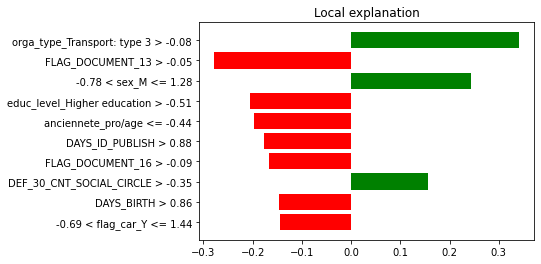

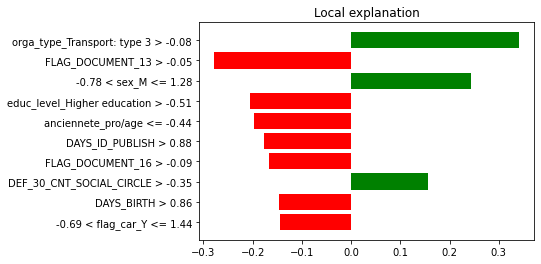

In [95]:
exp = explainer.explain_instance(X_test.iloc[0], adab.predict)
exp.as_pyplot_figure()

### J'applique ce modèle de feature importances sur l'échantillon test

In [96]:
df = data
df.head(1)

,SK_ID_CURR,adaboost_proba,adaboost_result,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,...,weekday_process_SATURDAY,type_suite_Family,flag_realty_Y,flag_car_Y,anciennete_pro/age,credit/revenu,credit/revenu/age,EXT_SOURCE_2/credit,EXT_SOURCE_2/age,nb_enf/age
0,100001,0.499798,0,-19241,-812,-1740.0,-2329,0.01885,1,18,...,0,0,1,0,0.121044,4.213333,-0.000219,0.000001,-0.000041,-0.0


In [97]:
X = df.iloc[:,3:67] # je ne prends pas l'ID

std_scale = preprocessing.StandardScaler().fit(X)
X_std = std_scale.transform(X)

X_featurenames = X.columns

In [98]:
X_std

array([[-0.73356892,  1.42703687, -0.7531145 , ..., -0.14313583,
        -0.44701329,  0.55004554],
       [-0.46147525,  0.91025768,  1.2265268 , ..., -0.19264759,
         1.21561732,  0.55004554],
       [-0.91781587, -0.28770147,  0.2526343 , ..., -0.351849  ,
        -0.03846335,  0.55004554],
       ...,
       [ 0.03370287,  0.98608595,  0.27311335, ...,  0.24552755,
        -0.36030005, -0.59455555],
       [ 0.48541998,  1.07529567, -1.39934223, ..., -0.39232356,
         0.16285072,  0.55004554],
       [ 0.48680703, -0.7445827 ,  0.85449076, ..., -0.09841553,
         0.11008344,  0.55004554]])

In [99]:
df.SK_ID_CURR

0        100001
1        100005
2        100013
3        100028
4        100038
          ...  
48702    456221
48703    456222
48704    456223
48705    456224
48706    456250
Name: SK_ID_CURR, Length: 48707, dtype: int64

In [100]:
X_featurenames

Index(['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_EMPLOYED', 'REGION_POPULATION_RELATIVE', 'FLAG_EMAIL',
       'HOUR_APPR_PROCESS_START', 'FLAG_DOCUMENT_6', 'FLAG_PHONE',
       'AMT_CREDIT', 'DAYS_REGISTRATION', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_16', 'AMT_INCOME_TOTAL', 'EXT_SOURCE_2',
       'REGION_RATING_CLIENT', 'REG_CITY_NOT_WORK_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'LIVE_CITY_NOT_WORK_CITY', 'FLAG_WORK_PHONE', 'CNT_CHILDREN',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'sex_M', 'educ_level_Lower secondary',
       'educ_level_Secondary / secondary special', 'income_type_Working',
       'orga_type_Business Entity Type 3', 'orga_type_Construction',
       'orga_type_Industry: type 3', 'orga_type_Restaurant',
       'orga_type_Trade: type 3', 'orga_type_Trade: type 7',
       'orga_type_Transport: type 3', 'name_contract_Cash loans',
       'housing_type_Rented apartment', 'housing_type_With pare

In [101]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_std),
                    feature_names = X_featurenames, 
                    class_names=['adaboost_result'],                             
                    verbose=True, mode='regression')

Intercept 0.2692825364814935
Prediction_local [0.33918441]
Right: 0


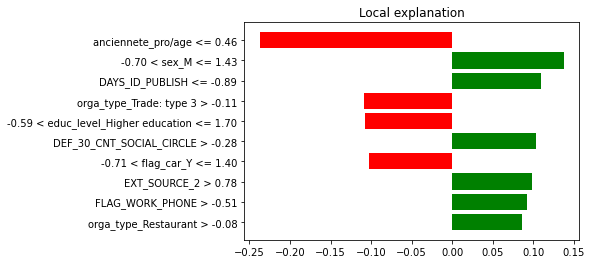

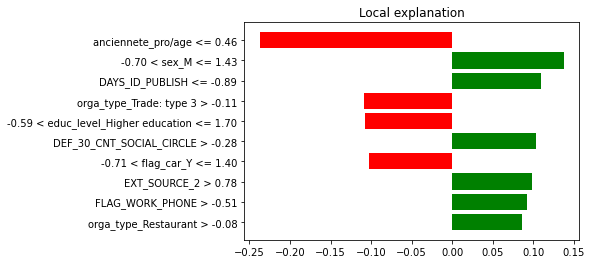

In [110]:
exp = explainer.explain_instance(X.iloc[0], adab.predict)
exp.as_pyplot_figure()

### Essai sur un autre client:

Intercept 0.2919589678866622
Prediction_local [0.12795796]
Right: 0


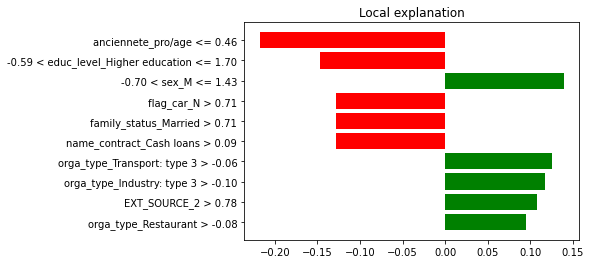

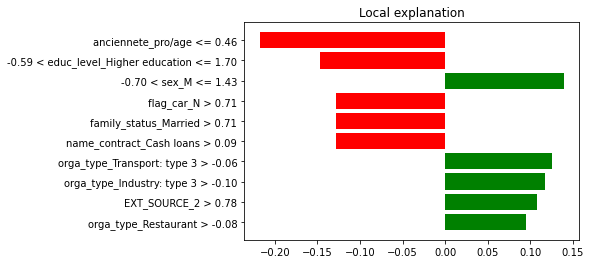

In [111]:
exp = explainer.explain_instance(X.iloc[8], adab.predict)
exp.as_pyplot_figure()

In [104]:
pd.DataFrame(exp.as_list())

,0,1
0,anciennete_pro/age <= 0.46,-0.218647
1,orga_type_Restaurant > -0.08,0.182104
2,-0.70 < sex_M <= 1.43,0.153735
3,-0.59 < educ_level_Higher education <= 1.70,-0.139867
4,name_contract_Cash loans > 0.09,-0.040564
5,income_type_Working > 0.99,-0.040564
6,educ_level_Secondary / secondary special > 0.66,-0.040564
7,FLAG_DOCUMENT_3 > 0.52,-0.040564
8,type_suite_Unaccompanied > 0.48,-0.040564
9,flag_car_N > 0.71,-0.040564
